<a href="https://colab.research.google.com/github/Logan-Stark/DS17-Unit-2-Project/blob/master/notebooks/Unit_2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 2 Project
## Can we predict if a movie is succesful

- DATA EXPLORATION AND IMPORT

In [1]:
 !pip install category_encoders==2.*
 !pip install eli5
 !pip install pdpbox
 !pip install shap

In [2]:
# Library import
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from category_encoders import OneHotEncoder, OrdinalEncoder
import eli5
import shap
from xgboost import XGBClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [3]:
# Reading in my dataset and checking it with .head()
df = pd.read_csv('https://raw.githubusercontent.com/Logan-Stark/DS17-Unit-2-Project/master/data/movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
# Using .info() to check column and dtypes.
# we have some null values that we will have to wrangle.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [5]:
# Using .describe to check statistics
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


# DATA WRANGLING

- For the first part of our wrangling we will need to create a Feature to measure success. We will divide gross revenue by Budget to see if each movie was able to break even

In [6]:
# dividing gross by budget
df['success_num'] = df['gross']/df['budget'] 

In [7]:
# funtion to creat a binary target 
# if a row is less than 1 the movie did not make its money back
# we will assign these rows to 0 for unsuccessful
# any rows greater than 1 will be assigned 1 for success

def normalise_row(row):
    if row['success_num'] < 1.5:
      return 0
    else:
      return 1

In [8]:
# using our function to create binary target
df['success'] = df.apply(lambda row : normalise_row(row), axis=1)

- Now we will split our data into train, val, and test sets.


In [9]:
# Split df into train & test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['success'], random_state=42)

In [10]:
# Split train into train & val
from sklearn.model_selection import train_test_split
train1 ,val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['success'], random_state=42)

In [11]:
# checking shapes of train, val, and test.
print('train shape',train.shape)
print('val shape',val.shape)
print('test shape',test.shape)

train shape (4034, 30)
val shape (807, 30)
test shape (1009, 30)


- Data wrangling and Data cleaning 

In [12]:
# wrangling data

def wrangle(X):

    """Wrangle train, validate, and test sets in the same way"""
    
 
    # Stop CopyWarning
    X = X.copy()
    
    # we will replace the nulls, and impute missing values later.
    X.dropna(inplace=True)

    #for col in cols_with_zeros:
       # X[col] = X[col].replace(0, np.nan)

    # Making New features
    X['veiwer_to_crit_ratio'] = X['num_user_for_reviews']/X['num_critic_for_reviews'] 
    
    
 

    # dropping columns
    # these columns either had problems or distracted our model 
    X = X.drop('genres', axis=1)
    X = X.drop('cast_total_facebook_likes', axis=1)
    X = X.drop('facenumber_in_poster', axis=1)
    X = X.drop('plot_keywords', axis=1)
    X = X.drop('movie_imdb_link', axis=1)
    X = X.drop('actor_2_facebook_likes', axis=1)
    X = X.drop('actor_1_facebook_likes', axis=1)
    X = X.drop('actor_3_facebook_likes', axis=1)
    X = X.drop('director_facebook_likes', axis=1)
    X = X.drop('gross', axis=1)
    X = X.drop('budget', axis=1)
    X = X.drop('movie_title', axis=1)
    X = X.drop('success_num', axis=1)
    X = X.drop('movie_facebook_likes', axis=1)
    X = X.drop('color', axis=1)
    X = X.drop('language', axis=1)
    return X

# DRY programming DON'T REPEAT YOURSELF
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

- Target selection and weeding out highly cardinal features 

In [13]:
# select our target 
target = 'success'

# make train without our target or id
train_features = train.drop(columns=[target])

# make numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# make a cardinality feature to help filter
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of relevant categorical data
categorical_features = cardinality[cardinality <=50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['num_critic_for_reviews', 'duration', 'num_voted_users', 'num_user_for_reviews', 'title_year', 'imdb_score', 'aspect_ratio', 'veiwer_to_crit_ratio', 'country', 'content_rating']


- Assigning X and y values to sets

In [14]:
# Now that our data sets have been streamlined and cleaned we 
# can assign our 3 sets of X and y values
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

- Checking our sets 

In [15]:
# Printing out shapes of sets
print(X_train.shape)
print(y_train.shape) 
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape )

(3019, 10)
(3019,)
(594, 10)
(594,)
(737, 10)
(737,)


# MAKING MODELS 
- For Our projects we are to make and fit at least 1 Linear model and 1 Tree ensemble Model
- I will coonstruct Baseline, Linear, and 3 Tree ensemble models


### Baseline model

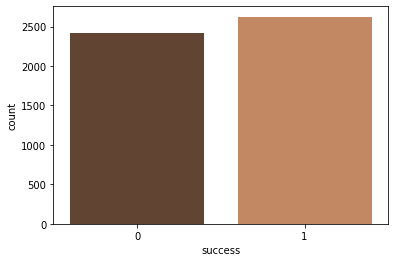

In [16]:
import seaborn as sns
sns.countplot(df['success'],palette='copper');
 #sns.countplot()
plt.savefig('Baseline2.png')

In [17]:
df['success'].value_counts(normalize=True)

1    0.520325
0    0.479675
Name: success, dtype: float64

  Our baseline for this dataset is 53.5

### Linear Model
- Our linear model will be made using a Logistic regression classsifier

In [18]:
# Define the model
logmodel = Pipeline([
                  ('ohe', OneHotEncoder(use_cat_names=True)),
                  ('scaler', StandardScaler()),  
                  ('impute', SimpleImputer()),
                  ('classifier',  LogisticRegression()
)
                  ])
# Fit the model
logmodel.fit(X_train, y_train)

# Print our Accuracy scores 
print('training accuracy:', logmodel.score(X_train, y_train))
print('Validation accuracy:', logmodel.score(X_val, y_val))

training accuracy: 0.7101689301093077
Validation accuracy: 0.7239057239057239


In [19]:
# Defining y_pred for the model and printing test scores
log_y_pred= logmodel.predict(X_test)
print('Test Score', logmodel.score(X_test,y_test))

Test Score 0.7150610583446404


### Tree Ensemble Models

#### Random Forest Model

In [20]:
# Define the model
rfmodel = Pipeline([
                  ('ohe', OneHotEncoder(use_cat_names=True)),
                  ('scaler', StandardScaler()),  
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier(
                      n_estimators=200,
                      n_jobs=-1,
                      max_depth=9))
                  ])
# Fit the model
rfmodel.fit(X_train, y_train)

# Print our Accuracy scores 
print('training accuracy:', rfmodel.score(X_train, y_train))
print('Validation accuracy:', rfmodel.score(X_val, y_val))

training accuracy: 0.7873468035773435
Validation accuracy: 0.797979797979798


In [21]:
# Defining y_pred for the model and printing test scores
rf_y_pred= rfmodel.predict(X_test)
print('Test Score', rfmodel.score(X_test,y_test ))

Test Score 0.7394843962008141


#### Gradient Boost Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
import category_encoders as ce

In [23]:
# Define the model
gbmodel = Pipeline([
                  ('ohe', OneHotEncoder(use_cat_names=True)),
                  ('scaler', StandardScaler()),  
                  ('impute', SimpleImputer()),
                  ('classifier',  GradientBoostingClassifier(n_estimators=200, random_state=42))
                  ])

# Fit the model
gbmodel.fit(X_train, y_train)

# Print our Accuracy scores 
print('training accuracy:', gbmodel.score(X_train, y_train))
print('Validation accuracy:', gbmodel.score(X_val, y_val))

training accuracy: 0.7986088108645247
Validation accuracy: 0.8114478114478114


In [24]:
# Defining y_pred for the model and printing test scores
gb_y_pred= gbmodel.predict(X_test)
print('Test Score', gbmodel.score(X_test,y_test))

Test Score 0.7394843962008141


#### XGBClassifier model

In [25]:
# Define the model
xgbmodel = Pipeline([
                  ('ohe', OneHotEncoder(use_cat_names=True)),
                  ('scaler', StandardScaler()),  
                  ('impute', SimpleImputer()),
                  ('classifier',  XGBClassifier(n_estimators=200, random_state=42)
)
                  ])

# Fit the model
xgbmodel.fit(X_train, y_train)

# Print our Accuracy scores 
print('training accuracy:', xgbmodel.score(X_train, y_train))
print('Validation accuracy:', xgbmodel.score(X_val, y_val))

training accuracy: 0.7893342166280225
Validation accuracy: 0.8131313131313131


In [26]:
# Defining y_pred for the model and printing test scores
xgb_y_pred= xgbmodel.predict(X_test)
print('Test Score', xgbmodel.score(X_test,y_test))

Test Score 0.7421981004070556


# Feature Importance and ELFI5
- Our best performing model was the XGB Model. lets take a look into what features are the most important to our model using a featur imprtance plot and a ELFI5 

#### Feature importance plot

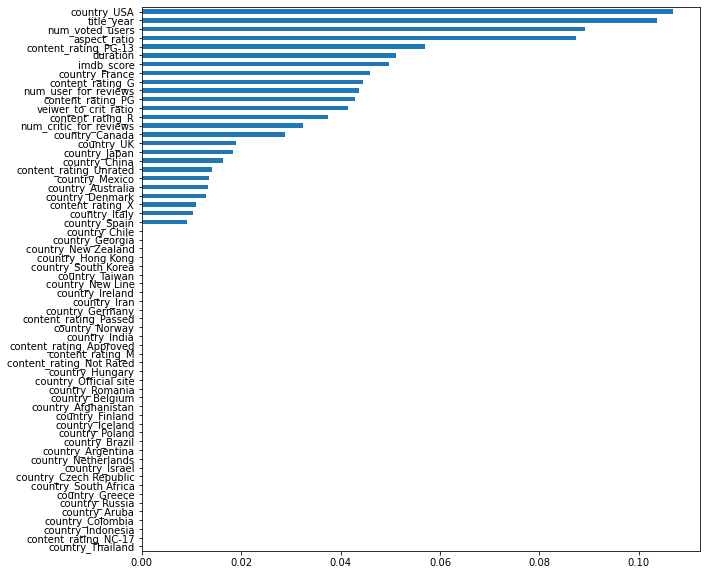

In [27]:
# Constructing a Feature importance plot

# Defining variables
model = xgbmodel.named_steps['classifier']
encoder = xgbmodel.named_steps['ohe']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

# Plotting and sorting values
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

#### ELFI5

In [28]:
# To construct our ELFI5 We cannot use a pipeline for fitting
# to get around this we will transform our prior to instantiate our model

# Making a Transformer
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

# Transforming the data
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

# Instantiating and fitting the model
model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
# Construct a permuter and fit with our data
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

# Fitting our permuter
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [30]:
# Showing ELFI5 results 
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist())

Weight,Feature
0.1121 ± 0.0216,num_voted_users
0.0444 ± 0.0108,title_year
0.0357 ± 0.0058,duration
0.0249 ± 0.0072,num_user_for_reviews
0.0215 ± 0.0150,aspect_ratio
0.0199 ± 0.0123,veiwer_to_crit_ratio
0.0152 ± 0.0111,imdb_score
0.0138 ± 0.0185,country
0.0111 ± 0.0062,num_critic_for_reviews
0.0051 ± 0.0067,content_rating


From the ELFi5 We can see that the feature that our model gives the most importance to are num_user_voted, duration, and title_year. We can also see that the Features language and color and not very important to the model. It might benefit our model to drop the least imprtant features.

# PDP Plots
- Now that we know what features are the most important to our model we can dive even deeper with PDP plots. A PDP plot will show us how much weight the different values of a given feature have. we will explore the top three important features.

In [31]:
# Set figure Parameters
plt.rcParams['figure.dpi'] = 72

In [32]:
# Define the feature to be examined
feature = 'num_voted_users'

# Define PDP variables
isolated = pdp_isolate(
    model=rfmodel,
    dataset=X_val,
    model_features= X_val.columns,
    feature = feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


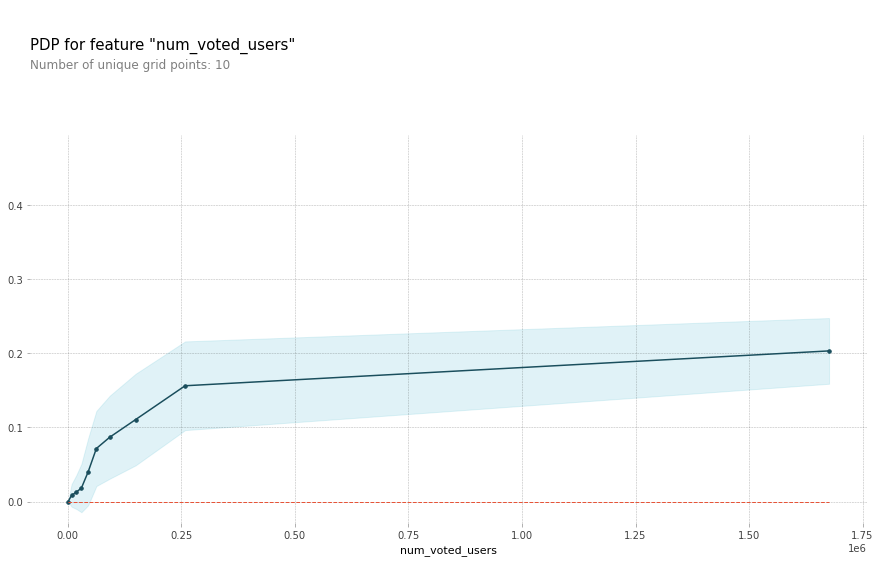

In [33]:
# Create PDP plot
pdp_plot(isolated, feature_name=feature);
plt.savefig('PDP_num_user_vote.png')

In [34]:
# Define the feature to be examined
feature = 'duration'

# Define PDP variables
isolated = pdp_isolate(
    model=rfmodel,
    dataset=X_val,
    model_features= X_val.columns,
    feature = feature)

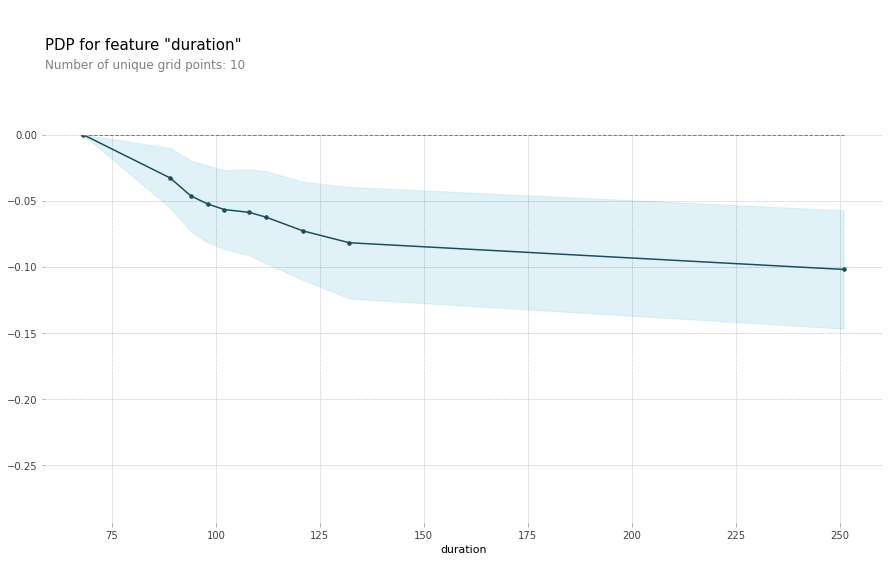

In [35]:
# Create PDP plot
pdp_plot(isolated, feature_name=feature);
plt.savefig('PDP_duration.png')

In [36]:
# Define the feature to be examined
feature = 'title_year'

# Define PDP variables
isolated = pdp_isolate(
    model=rfmodel,
    dataset=X_val,
    model_features= X_val.columns,
    feature = feature)

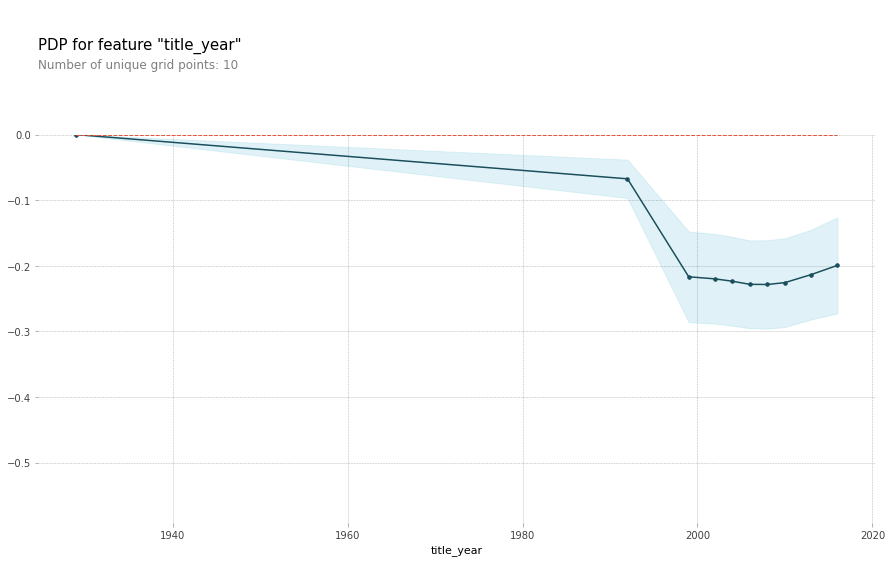

In [37]:
# Create PDP plot
pdp_plot(isolated, feature_name=feature);

# Shaply plots
- A shaply plot will let us see how the different features are weighed against one another in a given row

In [38]:
# We define a row to look into with our shaply plot 
row = X_val.iloc[[1]]
row

,num_critic_for_reviews,duration,num_voted_users,num_user_for_reviews,title_year,imdb_score,aspect_ratio,veiwer_to_crit_ratio,country,content_rating
46,654.0,123.0,465019,995.0,2013.0,7.0,2.35,1.521407,USA,PG-13


In [39]:
# To construct our Shaply plot we cannot use a pipeline for fitting
# to get around this we will process our data prior to instantiating our model

# Making a Processor
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

# Processing our data
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# Setting an Eval_set
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# Instantiating and fitting the model
model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.702822	validation_1-auc:0.716749
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.721299	validation_1-auc:0.716225
[2]	validation_0-auc:0.73361	validation_1-auc:0.728682
[3]	validation_0-auc:0.737029	validation_1-auc:0.729455
[4]	validation_0-auc:0.737672	validation_1-auc:0.72979
[5]	validation_0-auc:0.743085	validation_1-auc:0.741053
[6]	validation_0-auc:0.746205	validation_1-auc:0.746642
[7]	validation_0-auc:0.750871	validation_1-auc:0.750241
[8]	validation_0-auc:0.753999	validation_1-auc:0.755671
[9]	validation_0-auc:0.760666	validation_1-auc:0.757839
[10]	validation_0-auc:0.763343	validation_1-auc:0.760457
[11]	validation_0-auc:0.769202	validation_1-auc:0.767677
[12]	validation_0-auc:0.769349	validation_1-auc:0.770874
[13]	validation_0-auc:0.771169	validation_1-auc:0.771324
[14]	validation_0-auc:0.774833	validation_1-auc:0.777406


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

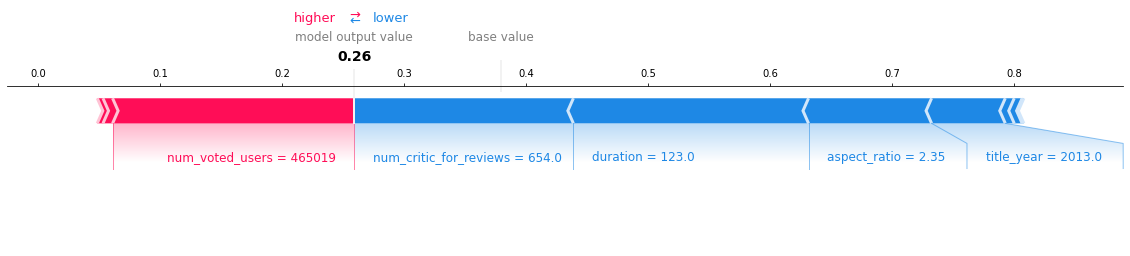

In [40]:
# Defining shaply variables
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

# Making shaply plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    matplotlib=True,
    show = False,
    link='logit' # For classification, this shows predicted probabilities
)

plt.savefig('working_Shap')
